# GTFS stop count

Carl Higgs, Global Indicators project, 2020

This notebook is used to count GTFS stops within 500m of the urban study region boundaries of cities in the global indicators study.



## Import libraries and city specific parameters

In [1]:
import os
import numpy as np
import fiona
import pandas as pd
import geopandas as gpd
import argparse
import json
with open('../process/configuration/cities.json') as f:
  city_data = json.load(f)
exec(open('../process/data/GTFS/gtfs_config.py').read())

import warnings
# filter out RuntimeWarnings, due to geopandas/fiona read file spam
# https://stackoverflow.com/questions/64995369/geopandas-warning-on-read-file
warnings.filterwarnings("ignore",category=RuntimeWarning)


## Proof of concept

The below plot illustrates the subset (yellow) of all GTFS recorded stops (blue) within 500m of Odense' urban study region

odense_stops_headway_20190405_20190605


<AxesSubplot:>

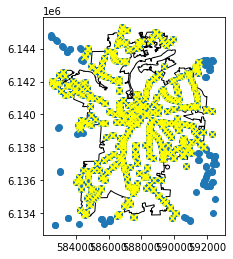

In [2]:
# get gtfs data
gtfs_analysis_date = '2021-06-16'
gtfs_gpkg = f'../process/data/GTFS/gtfs_frequent_transit_headway_{gtfs_analysis_date}_python.gpkg'

# for city in city_data['gpkgNames']:
for city in ['odense']:
    # get gtfs data
    if GTFS[city]!=[]:
        if city in dissolve_cities:
            gtfs_layer = f"{city}_stops_average_feeds_headway_{GTFS[city][-1]['start_date_mmdd']}_{GTFS[city][-1]['end_date_mmdd']}"
        else:
            gtfs_layer = f"{city}_stops_headway_{GTFS[city][-1]['start_date_mmdd']}_{GTFS[city][-1]['end_date_mmdd']}"
        print(gtfs_layer)
        gtfs_data = gpd.read_file(gtfs_gpkg,layer=gtfs_layer)
        # get city data
        region = gpd.read_file(f"../process/data/output/{city_data['gpkgNames'][city]}",layer='urban_study_region')
    
    
buffered_region = region.buffer(500).unary_union
inner_points = gtfs_data[gtfs_data.geometry.within(buffered_region)] 
base = region.plot(color='white',edgecolor='black')
gtfs_data.plot(ax=base,marker='o')
#buffered_region.plot(ax=base,color='none')
inner_points.plot(ax=base,marker='x',color='yellow')

In [3]:
print(f"{len(inner_points)}/{len(gtfs_data)} of the GTFS points selected by bounding box within 500m of study region")

545/635 of the GTFS points selected by bounding box within 500m of study region


## Proof of concept of equivalence of statistics
City|tot_stops|headway<=30	headway<=20	pct_headway<=30	pct_headway<=20
Odense|635|372|245|58.58|38.58

In [4]:
stats = {}
stats['n']=len(gtfs_data)
stats['n_headway_leq20'] = len(gtfs_data.query('headway<=20'))
stats['n_headway_leq30'] = len(gtfs_data.query('headway<=30'))
stats['pct_headway_leq20'] = round(100*stats['n_headway_leq20']/stats['n'],2)
stats['pct_headway_leq30'] = round(100*stats['n_headway_leq30']/stats['n'],2)
print(f"previous statistics for Odense (stops within bounding box for buffered region; can't recall if 1600m or 10,000m - but some overflow):\n{stats}")

previous statistics for Odense (stops within bounding box for buffered region; can't recall if 1600m or 10,000m - but some overflow):
{'n': 635, 'n_headway_leq20': 245, 'n_headway_leq30': 372, 'pct_headway_leq20': 38.58, 'pct_headway_leq30': 58.58}


In [5]:
stats = {}
stats['n']=len(inner_points)
stats['n_headway_leq20'] = len(inner_points.query('headway<=20'))
stats['n_headway_leq30'] = len(inner_points.query('headway<=30'))
stats['pct_headway_leq20'] = round(100*stats['n_headway_leq20']/stats['n'],2)
stats['pct_headway_leq30'] = round(100*stats['n_headway_leq30']/stats['n'],2)
print(f"updated statistics for Odense (stops within 500m of urban boundary):\n{stats}")

updated statistics for Odense (stops within 500m of urban boundary):
{'n': 545, 'n_headway_leq20': 231, 'n_headway_leq30': 334, 'pct_headway_leq20': 42.39, 'pct_headway_leq30': 61.28}


## Analysis

In [6]:
# get gtfs data
gtfs_analysis_date = '2021-06-16'
gtfs_gpkg = f'../process/data/GTFS/gtfs_frequent_transit_headway_{gtfs_analysis_date}_python.gpkg'

stats = {}
for city in city_data['gpkgNames']:
    stats[city]={}
    # get gtfs data
    if GTFS[city]!=[]:
        if city in dissolve_cities:
            gtfs_layer = f"{city}_stops_average_feeds_headway_{GTFS[city][-1]['start_date_mmdd']}_{GTFS[city][-1]['end_date_mmdd']}"
        else:
            gtfs_layer = f"{city}_stops_headway_{GTFS[city][-1]['start_date_mmdd']}_{GTFS[city][-1]['end_date_mmdd']}"
        #print(gtfs_layer)
        gtfs_data = gpd.read_file(gtfs_gpkg,layer=gtfs_layer)
        # get city data
        region = gpd.read_file(f"../process/data/output/{city_data['gpkgNames'][city]}",layer='urban_study_region')
        buffered_region = region.buffer(500).unary_union
        inner_points = gtfs_data[gtfs_data.geometry.within(buffered_region)] 
        stats[city]['n']=len(inner_points)
        stats[city]['n_headway_leq30'] = len(inner_points.query('headway<=30'))
        stats[city]['n_headway_leq20'] = len(inner_points.query('headway<=20'))
        stats[city]['pct_headway_leq30'] = round(100*stats[city]['n_headway_leq30']/stats[city]['n'],2)
        stats[city]['pct_headway_leq20'] = round(100*stats[city]['n_headway_leq20']/stats[city]['n'],2)
        print(f"{city}: {stats[city]}")
    else:
        stats[city]={}
        print(f"{city}: {stats[city]}")

adelaide: {'n': 6064, 'n_headway_leq30': 4865, 'n_headway_leq20': 2611, 'pct_headway_leq30': 80.23, 'pct_headway_leq20': 43.06}
auckland: {'n': 10044, 'n_headway_leq30': 8252, 'n_headway_leq20': 4416, 'pct_headway_leq30': 82.16, 'pct_headway_leq20': 43.97}
baltimore: {'n': 4145, 'n_headway_leq30': 2863, 'n_headway_leq20': 2171, 'pct_headway_leq30': 69.07, 'pct_headway_leq20': 52.38}
bangkok: {'n': 6218, 'n_headway_leq30': 6111, 'n_headway_leq20': 3759, 'pct_headway_leq30': 98.28, 'pct_headway_leq20': 60.45}
barcelona: {'n': 3138, 'n_headway_leq30': 2828, 'n_headway_leq20': 2485, 'pct_headway_leq30': 90.12, 'pct_headway_leq20': 79.19}
belfast: {'n': 1550, 'n_headway_leq30': 1159, 'n_headway_leq20': 875, 'pct_headway_leq30': 74.77, 'pct_headway_leq20': 56.45}
bern: {'n': 410, 'n_headway_leq30': 372, 'n_headway_leq20': 321, 'pct_headway_leq30': 90.73, 'pct_headway_leq20': 78.29}
chennai: {'n': 58, 'n_headway_leq30': 35, 'n_headway_leq20': 35, 'pct_headway_leq30': 60.34, 'pct_headway_leq20

In [7]:
df = pd.DataFrame(stats)
df = df.transpose().fillna('-')
df.index = [x.title().replace('_',' ') for x in df.index]
df.to_csv(f'GTFS stop counts within 500m of urban study region - {gtfs_analysis_date}.csv')
df

,n,n_headway_leq30,n_headway_leq20,pct_headway_leq30,pct_headway_leq20
Adelaide,6064.0,4865.0,2611.0,80.23,43.06
Auckland,10044.0,8252.0,4416.0,82.16,43.97
Baltimore,4145.0,2863.0,2171.0,69.07,52.38
Bangkok,6218.0,6111.0,3759.0,98.28,60.45
Barcelona,3138.0,2828.0,2485.0,90.12,79.19
Belfast,1550.0,1159.0,875.0,74.77,56.45
Bern,410.0,372.0,321.0,90.73,78.29
Chennai,58.0,35.0,35.0,60.34,60.34
Cologne,973.0,881.0,649.0,90.54,66.7
Ghent,-,-,-,-,-
